# **Scenario 3 : Data Generation from a Probability Distribution**

As before, we train ANNs or define our own functions to calculate each variable in the DAG. However, instead of a Monte Carlo (agent based) approach, we use Causal Jazz to build a discretised probability distribution.


Import the usual suspects and the pmf module from causaljazz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

from causaljazz.visualiser import Visualiser
from causaljazz.cpu import pmf
from causaljazz.cpu import CausalFunction
from causaljazz.inference import TEDAG_FUNCTION
from causaljazz.inference import TEDAG
import causaljazz.data as data

from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import layers

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


# **Helper Functions**

In [2]:
# Return the approximate discretised probability mass function for a normal distribution with x_mean and x_sd. The discretisation goes from x_min to x_max with res bins.
def generateGaussianNoisePmf(x_min, x_max, x_mean, x_sd, res):
    x_space = np.linspace(x_min, x_max, res)
    x_dist = [a * ((x_max-x_min)/res) for a in norm.pdf(x_space, x_mean, x_sd)]
    x_pmf = [a / sum(x_dist) for a in x_dist]
    return x_pmf

Load the original data into an ND-array structure.
The original data is made up of up to 25 sets of 1000 data points. Setting number_of_experiments higher improves the functions.

In [3]:
csv_names = ['X1', 'X2', 'LC', 'X3', 'SF']

# Load the data into an array
ground = [] # The ground truth array
number_of_experiments = 25
with open('ground.csv') as csvfile:
    ground_reader = csv.DictReader(csvfile)
    for row in ground_reader:
        if int(row['Sim']) > number_of_experiments:
            break
        d = [float(a) for a in [row[k] for k in csv_names]]
        ground += [d]

# Normalise it otherwise training doesn't work!
max_vals = np.max(ground, axis=0)
min_vals = np.min(ground, axis=0)
ground = ((np.array(ground)-min_vals)/(max_vals-min_vals))

Set grid resolution variables and flags.

In [4]:
generate_models = True

input_res = 10
output_res = 30
output_buffer = 5
total_output_size = 2*(output_res+output_buffer)

# **Latent Function C**

Before learning the ANN functions, let's design our function for C.<br>

*func_c* takes two inputs, X<sub>1</sub> and X<sub>2</sub>, and returns a distribution across two values, 0 and 1.

To achieve the expected path coefficients, we first define the expected value of a non-dichotomised (non-binary) C based on X<sub>1</sub> and X<sub>2</sub>.
<br><br>
E[C] <- 0.3X<sub>1</sub> + 0.3X<sub>2</sub>
<br><br>
Next, we must define the variance of C for each value of X<sub>1</sub> and X<sub>2</sub>. For simplicity we will assume that the variance is normally distributed around the expected value with a standard deviation of 1. The conditional distributions could be dependent on the inputs and considerably more complicated than a normal distribution. Note that any skew or bias in the distribution will affect the resulting covariance.<br><br>
If the latent variable is not to be processed further (for example dichotomised), the function is simple and can return a normal distribution around the expected value. However, this imparts no new information from the latent variable beyond some additional variance - which may be all that is required (enigmatic variation). In this case, though, we also wish to capture a 30/70 split between high and low risk groups. <br><br>
To get a distribution across two values, 1 and 0, we need to dichotamise the joint distribution so that 30% falls into the high-risk group (C=1). This step has to be performed on the full joint distribution of X<sub>1</sub>, X<sub>2</sub>, and C so that lower values of X<sub>1</sub> and X<sub>2</sub> are more likely to appear in the low-risk group.



In [5]:
def func_c_exp(y):
  x1 = np.array(y)[:,0]
  x2 = np.array(y)[:,1]

  out = np.reshape((0.3*x1 + 0.3*x2), (np.array(y).shape[0],1))
  print(out.shape)
  return out

def func_c_noise(y):
  x1 = np.array(y)[:,0]
  x2 = np.array(y)[:,1]

  out = np.array([generateGaussianNoisePmf(-0.5, 0.5, 0, 0.1, total_output_size) for a in range(np.array(y).shape[0])]).T
  print(out.shape)
  return out

def func_c_sampled(y):
  x1 = y[0]
  x2 = y[1]

  exp_c = 0.3*x1 + 0.3*x2
  cont_c = np.random.normal(loc=exp_c, scale=0.1)
  return cont_c
  #if cont_c > 0.2:
  #  return 1
  #else:
  #  return 0

Learn the functions for X<sub>2</sub>, X<sub>3</sub>, and S. In this example dataset, X<sub>1</sub> is normally distributed around 0.0 with a standard deviation of 1.0.

In [6]:
# X2 <- X1
data_points = np.stack([ground[:,0], ground[:,1]])
func_e_x2, func_x2_noise = data.trainANN('x2_given_x1', generate_models, data_points, [input_res], output_res, output_buffer)

# C <- X1,X2
generated_c = np.array([func_c_sampled(x) for x in ground[:,:2]])

# X3 <- X1,X2,C
data_points = np.stack([ground[:,0], ground[:,1], generated_c, ground[:,3]])
func_e_x3, func_x3_noise = data.trainANN('x3_given_x1x2c', generate_models, data_points, [input_res,input_res,input_res], output_res, output_buffer)

# S <- X1,X2,C,X3
data_points = np.stack([ground[:,0], ground[:,1], generated_c, ground[:,3], ground[:,4]])
func_e_s, func_s_noise  = data.trainANN('s_given_x1x2cx3', generate_models, data_points, [input_res,input_res,input_res,input_res], output_res, output_buffer)

Epoch 1/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0423 - val_loss: 0.0132
Epoch 2/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 3/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 4/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 5/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 6/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 7/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 8/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 9/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 10/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 11/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 12/2000
175/175 ━━━━━━━━

Epoch 44/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6732e-06 - val_loss: 3.8487e-06
Epoch 45/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4264e-06 - val_loss: 3.9849e-06
Epoch 46/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7447e-06 - val_loss: 3.8260e-06
Epoch 47/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4491e-06 - val_loss: 3.8693e-06
Epoch 48/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7981e-06 - val_loss: 3.9275e-06
Epoch 49/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9970e-06 - val_loss: 3.8112e-06
Epoch 50/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8087e-06 - val_loss: 3.9258e-06
Epoch 51/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4198e-06 - val_loss: 3.8954e-06
Epoch 52/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2115e-06 - val_loss: 3.8019e-06
Epoch 53/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1209e-06 - val_loss: 3.8027e-06
7832.816748396023 (25000,)
Epo

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8439e-04 - val_loss: 1.7682e-04
Epoch 23/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9181e-04 - val_loss: 1.7707e-04
Epoch 24/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7494e-04 - val_loss: 1.7659e-04
Epoch 25/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8237e-04 - val_loss: 1.7765e-04
Epoch 26/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8723e-04 - val_loss: 1.7770e-04
Epoch 27/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7495e-04 - val_loss: 1.7703e-04
Epoch 1/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0243 - val_loss: 0.0149
Epoch 2/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0148
Epoch 3/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0148
Epoch 4/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0150
Epoch 5/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss:

Epoch 11/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4915e-04 - val_loss: 7.6574e-04
Epoch 12/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3492e-04 - val_loss: 7.5787e-04
Epoch 13/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3704e-04 - val_loss: 7.5896e-04
Epoch 14/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5840e-04 - val_loss: 7.5706e-04
Epoch 15/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4319e-04 - val_loss: 7.5826e-04
Epoch 16/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8413e-04 - val_loss: 7.5617e-04
Epoch 17/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5120e-04 - val_loss: 7.5689e-04
Epoch 18/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5145e-04 - val_loss: 7.5841e-04
Epoch 19/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7087e-04 - val_loss: 7.5847e-04
Epoch 20/2000
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5982e-04 - val_loss: 7.5536e-04
Epoch 21/2000
175/175 ━━━━━━━━

# **Causal Jazz Simulation**

In [7]:
# Define the Causal Jazz transition function
# It takes the name of the python function, the number of inputs, and a flag to say this is a function
# that returns a discretised distribution (as opposed to a single value)
trans_x2_e = CausalFunction(func_e_x2, 1)
trans_x2_noise = CausalFunction(func_x2_noise, 1, transition_function=True)
trans_lc_e = CausalFunction(func_c_exp, 2)
trans_lc_noise = CausalFunction(func_c_noise, 2, transition_function=True)
trans_x3_e = CausalFunction(func_e_x3, 3)
trans_x3_noise = CausalFunction(func_x3_noise, 3, transition_function=True)
trans_s_e  = CausalFunction(func_e_s, 4)
trans_s_noise  = CausalFunction(func_s_noise, 4, transition_function=True)

# Make a function to sum things
# Helper function to sum the inputs (in this case, sum the expected value and the noise)
def func_sum(y):
  out = np.reshape(np.sum(y, axis=-1), (np.array(y).shape[0],1))
  print(out.shape)
  return out

trans_sum = CausalFunction(func_sum, 2)

# Template distribution space for each variable
# The templates must have the same cell widths as the pmfs used to train the functions
x2_template = pmf(np.array([]), np.array([0.0]), np.array([1.0 / output_res]), 0.000001) # The minimum mass should obviously be 0
lc_template = pmf(np.array([]), np.array([0.0]), np.array([1.0 / output_res]), 0.000001)
x3_template = pmf(np.array([]), np.array([0.0]), np.array([1.0 / output_res]), 0.000001)
s_template  = pmf(np.array([]), np.array([0.0]), np.array([1.0 / output_res]), 0.000001)

# Define the variable names for each function in TEDAG
tedag_func_x2_e = TEDAG_FUNCTION(['X1'], 'X2E', 0, trans_x2_e, x2_template)
tedag_func_x2_noise = TEDAG_FUNCTION(['X1'], 'X2N', 0, trans_x2_noise, x2_template)
tedag_func_x2 = TEDAG_FUNCTION(['X2E', 'X2N'], 'X2', 0, trans_sum, x2_template)
tedag_func_lc_e = TEDAG_FUNCTION(['X1', 'X2'], 'LCE', 0, trans_lc_e, lc_template)
tedag_func_lc_noise = TEDAG_FUNCTION(['X1', 'X2'], 'LCN', 0, trans_lc_noise, lc_template)
tedag_func_lc = TEDAG_FUNCTION(['LCE', 'LCN'], 'LC', 0, trans_sum, lc_template)
tedag_func_x3_e = TEDAG_FUNCTION(['X1', 'X2', 'LC'], 'X3E', 0, trans_x3_e, x3_template)
tedag_func_x3_noise = TEDAG_FUNCTION(['X1', 'X2', 'LC'], 'X3N', 0, trans_x3_noise, x3_template)
tedag_func_x3 = TEDAG_FUNCTION(['X3E', 'X3N'], 'X3', 0, trans_sum, x3_template)
tedag_func_s_e  = TEDAG_FUNCTION(['X1', 'X2', 'LC', 'X3'], 'SE', 0, trans_s_e, s_template)
tedag_func_s_noise  = TEDAG_FUNCTION(['X1', 'X2', 'LC', 'X3'], 'SN', 0, trans_s_noise, s_template)
tedag_func_s = TEDAG_FUNCTION(['SE', 'SN'], 'S', 0, trans_sum, s_template)

# Initialise the TEDAG
tedag = TEDAG(1, [tedag_func_x2_e,tedag_func_x2_noise,tedag_func_lc_e,tedag_func_lc_noise,tedag_func_x2,tedag_func_lc,tedag_func_x3_e,tedag_func_x3_noise,tedag_func_x3,tedag_func_s_e,tedag_func_s_noise,tedag_func_s], observables=['X1', 'X2', 'LC', 'X3', 'S'], verbose=True)

# Add a single intervention to set X1
x1 = generateGaussianNoisePmf(-3.0,3.0,0.0,1.0, output_res)
x1 /= max_vals[0]
x1_pmf = pmf(np.array(x1), np.array([0.0]), np.array([1.0/output_res]), 0.000001)
tedag.addIntervention(['X1'], 0, x1_pmf)

# Forward calculate the distributions
while tedag.findNextFunctionAndApply(0):
    continue

In findNextFunctionAndApply, found function X2E at iteration 0
Required input variables are: ['X10']
Input pmf is ['X10']
Output pmf has variables ['X10', 'X2E0']
Variables in the input pmf required by the function are [0]
Current Nodes: ['X10', 'X2E0']
In findNextFunctionAndApply, found function X2N at iteration 0
Required input variables are: ['X10']
Input pmf is ['X10', 'X2E0']
Output pmf has variables ['X10', 'X2E0', 'X2N0']
Variables in the input pmf required by the function are [0]
Current Nodes: ['X10', 'X2E0', 'X2N0']
In findNextFunctionAndApply, found function X2 at iteration 0
Required input variables are: ['X2E0', 'X2N0']
Input pmf is ['X10', 'X2E0', 'X2N0']
Output pmf has variables ['X10', 'X2E0', 'X2N0', 'X20']
Variables in the input pmf required by the function are [1, 2]
(560, 1)
Node X2E0 no longer required. Deleting...
Node X2N0 no longer required. Deleting...
Current Nodes: ['X10', 'X20']
In findNextFunctionAndApply, found function LCE at iteration 0
Required input va

Let's plot the points and compare to the original data.

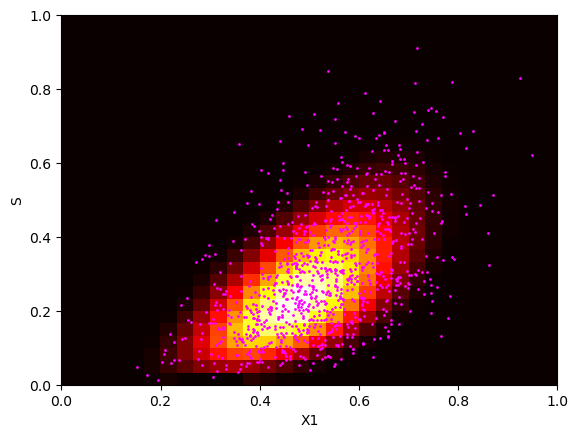

In [8]:
space = [0.0, 1.0, 0.0, 1.0]
var_names = ['X1', 'S']

fig = plt.figure(1, dpi=100)

tedag_pmf = tedag.getPmfForIteration(var_names, 0)
if tedag_pmf is not None:
    node_indices = [[n.key for n in tedag_pmf.nodes].index(a+str(0)) for a in var_names]
    coords, centroids, vals = tedag_pmf.pmf.calcMarginal(node_indices)

    vals = np.array(vals)
    coords = np.array(coords)
    grid = np.zeros((output_res,output_res))
    for c in range(len(vals)):
        ws = [tedag_pmf.pmf.cell_widths[node_indices[0]],tedag_pmf.pmf.cell_widths[node_indices[1]]]
        os = [tedag_pmf.pmf.origin[node_indices[0]], tedag_pmf.pmf.origin[node_indices[1]]]
        cs = [coords[c][0]+(int((os[0]-space[0])/ws[0])), coords[c][1]+(int((os[1]-space[2])/ws[1]))]
        cs = [c if c < output_res else output_res-1 for c in cs]
        cs = [c if c >= 0 else 0 for c in cs]
        grid[int(cs[0]),int(cs[1])] = vals[c]
    grid = np.transpose(grid)

    plt.xlim([space[0],space[1]])
    plt.xlabel(var_names[0])
    plt.ylabel(var_names[1])
    plt.ylim([space[2],space[3]])
    plt.imshow(grid, cmap='hot', origin='lower', extent=(space[0],space[1],space[2],space[3]), aspect='auto')

    plt.scatter(ground[:1000,0],ground[:1000,4],s=1.0,color='#FF00FF')
    #plt.scatter(ground[:1000,0],ground[:1000,1],s=0.2)
plt.show(block=False)
plt.close()